# EEG data import

In [1]:
import mne
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from sklearn.cluster import KMeans
from scipy.stats import skew, kurtosis
from mne.preprocessing import ICA
from scipy.stats import zscore
# Load the EDF file
raw_data = mne.io.read_raw_edf("fullData/Subject01_1.edf", preload=True)

Extracting EDF parameters from /Users/sid/Documents/GitHub/EEG analysis/EEG-analysis/Dataset 4/fullData/Subject01_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...


# Preprocessing

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Fitting ICA to data using 21 channels (please be patient, this may take a while)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Selecting by number: 20 components
Fitting ICA took 2.3s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 3 ICA components
    Projecting back using 21 PCA components


/var/folders/zh/hy06z30s077_msnbh4__6xjc0000gn/T/ipykernel_43971/3579679534.py:7: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (16) and smallest (8.4e-10) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 17
  ica.fit(raw_data_highpass)


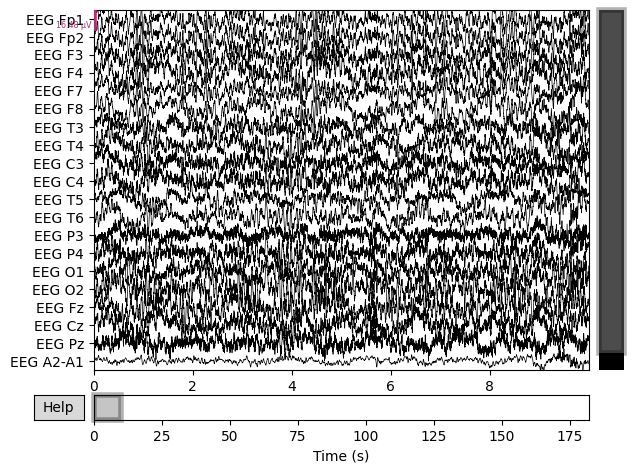

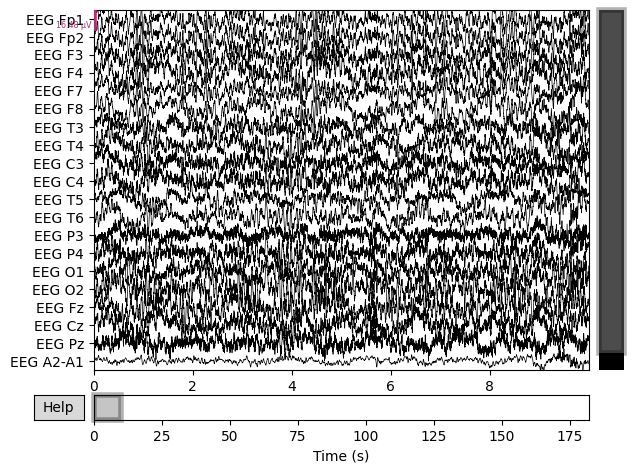

In [2]:
# Apply high-pass filter with a lower bound of 1 Hz
raw_data_highpass = raw_data.copy().filter(l_freq=1., h_freq=None)

# Fit ICA to the high-pass filtered data
ica = ICA(n_components=20, random_state=97, max_iter=800)
try:
    ica.fit(raw_data_highpass)
except Exception as e:
    print(f"An error occurred while fitting ICA: {e}")
    
# For the purpose of this example, we'll assume that the first three components are artifacts (this is just an assumption for demonstration)
ica.exclude = [0, 1, 2]

# Apply the ICA to remove artifacts
raw_data_clean = ica.apply(raw_data_highpass.copy(), exclude=ica.exclude)

# Plot the clean data for the first 10 seconds
raw_data_clean.plot(duration=10, n_channels=20, scalings='auto', title='Cleaned EEG Data')

In [3]:
# Calculate the z-scores of the channel data
data, times = raw_data_clean[:, :]
channel_means = np.mean(data, axis=1)
channel_stds = np.std(data, axis=1)
z_scores = zscore(channel_means)

# Set a z-score threshold to identify bad channels
z_threshold = 3.0

# Identify bad channels based on the z-score threshold
bad_channels = np.where(np.abs(z_scores) > z_threshold)[0]
bad_channel_names = [raw_data_clean.ch_names[i] for i in bad_channels]

# Annotate the bad channels in the raw data
raw_data_clean.info['bads'] = bad_channel_names

# Print out the identified bad channels
bad_channel_names


['ECG ECG']

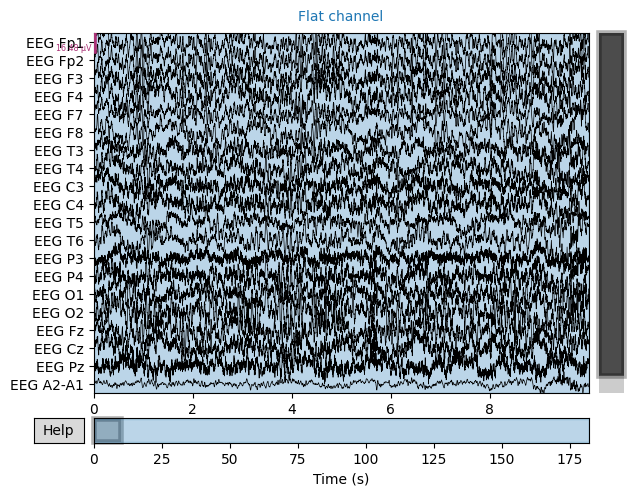

(['EEG A2-A1'], <MNEBrowseFigure size 640x480 with 4 Axes>)

In [4]:
# Calculate variance for each channel
channel_variances = np.var(data, axis=1)

# Set a low variance threshold to identify flat channels (this is just an example value and may need to be adjusted)
variance_threshold = 1e-11

# Identify flat channels based on the low variance threshold
flat_channels = np.where(channel_variances < variance_threshold)[0]
flat_channel_names = [raw_data_clean.ch_names[i] for i in flat_channels]

# Create custom annotations for flat channels
flat_annotations = mne.Annotations(onset=[0], duration=[raw_data_clean.times[-1]], description=['Flat channel'])

# Add the annotations to the raw data object
if flat_channels.size > 0:
    raw_data_clean.set_annotations(flat_annotations)

# Print out the identified flat channels and plot the data with annotations
flat_channel_names, raw_data_clean.plot(duration=10, n_channels=20, scalings='auto', title='Data with Annotations for Flat Channels')


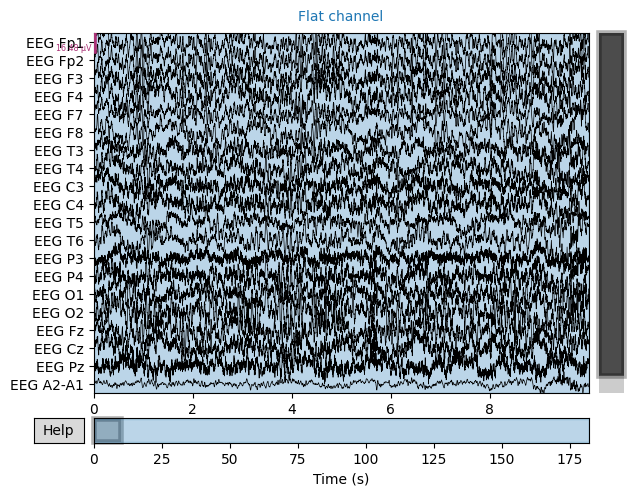

(['EEG Fp1',
  'EEG Fp2',
  'EEG F3',
  'EEG F4',
  'EEG F7',
  'EEG F8',
  'EEG T3',
  'EEG T4',
  'EEG C3',
  'EEG C4',
  'EEG T5',
  'EEG T6',
  'EEG P3',
  'EEG P4',
  'EEG O1',
  'EEG O2',
  'EEG Fz',
  'EEG Cz',
  'EEG Pz',
  'EEG A2-A1'],
 <MNEBrowseFigure size 640x480 with 4 Axes>)

In [5]:
# Calculate variance for each channel
channel_variances = np.var(data, axis=1)

# Set a low variance threshold to identify flat channels (this is just an example value and may need to be adjusted)
variance_threshold = 1e-10

# Identify flat channels based on the low variance threshold
flat_channels = np.where(channel_variances < variance_threshold)[0]
flat_channel_names = [raw_data_clean.ch_names[i] for i in flat_channels]

# Create custom annotations for flat channels
flat_annotations = mne.Annotations(onset=[0], duration=[raw_data_clean.times[-1]], description=['Flat channel'])

# Add the annotations to the raw data object
if flat_channels.size > 0:
    raw_data_clean.set_annotations(flat_annotations)

# Print out the identified flat channels and plot the data with annotations
flat_channel_names, raw_data_clean.plot(duration=10, n_channels=20, scalings='auto', title='Data with Annotations for Flat Channels')


# Filtering

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 165 samples (0.330 sec)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 sec)



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,


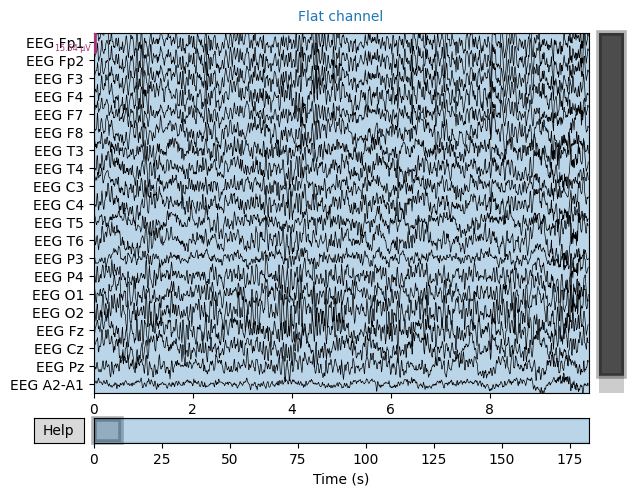

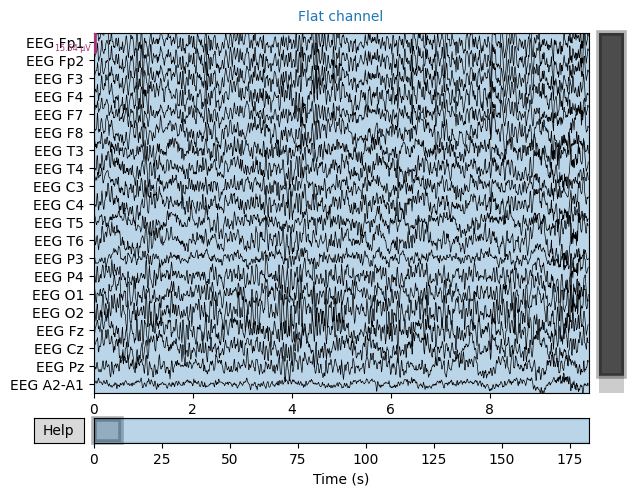

In [6]:
# Create a copy of the cleaned data to apply the filters
raw_data_filtered = raw_data_clean.copy()

# Apply High-pass filter to remove slow drifts or DC offsets (cutoff frequency = 1 Hz)
raw_data_filtered.filter(l_freq=1., h_freq=None)

# Apply Low-pass filter to remove high-frequency noise (cutoff frequency = 40 Hz)
raw_data_filtered.filter(l_freq=None, h_freq=40.)

# Apply Notch filter to remove power line interference (60 Hz for US)
freqs = (60,)  # Tuple indicating the frequencies to be notched out
raw_data_filtered.notch_filter(freqs=freqs)

# Plot the filtered data for the first 10 seconds
raw_data_filtered.plot(duration=10, n_channels=20, scalings='auto', title='Filtered EEG Data')


# Spectral decomposition

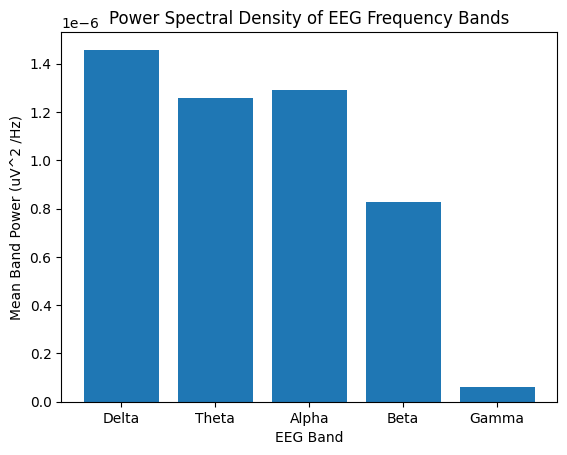

{'Delta': 1.457510726810714e-06,
 'Theta': 1.2579093716318504e-06,
 'Alpha': 1.2908921584415004e-06,
 'Beta': 8.288866962713713e-07,
 'Gamma': 6.26508047827676e-08}

In [7]:
# Define the EEG frequency bands
eeg_bands = {'Delta': (0.5, 4),
             'Theta': (4, 8),
             'Alpha': (8, 12),
             'Beta': (12, 30),
             'Gamma': (30, 100)}

# Select a segment of EEG data (e.g., first 5 seconds) from a single channel (e.g., first channel)
start, stop = raw_data_filtered.time_as_index([0, 5])  # 0 to 5 s
data_segment, times_segment = raw_data_filtered[:, start:stop]
data_channel_1 = data_segment[0, :]

# Apply FFT to the data segment
frequencies = np.fft.fftfreq(len(data_channel_1), 1 / raw_data_filtered.info['sfreq'])
positive_frequencies = frequencies[frequencies >= 0]
fft_values = fft(data_channel_1)
fft_values = 2 / len(positive_frequencies) * np.abs(fft_values[frequencies >= 0])

# Create a dictionary to store the frequency band powers
eeg_band_fft = dict()
for band, freq_range in eeg_bands.items():
    freq_mask = (positive_frequencies >= freq_range[0]) & (positive_frequencies <= freq_range[1])
    eeg_band_fft[band] = np.mean(fft_values[freq_mask])

# Plot the power for each EEG frequency band
plt.figure()
plt.bar(eeg_band_fft.keys(), eeg_band_fft.values())
plt.xlabel('EEG Band')
plt.ylabel('Mean Band Power (uV^2 /Hz)')
plt.title('Power Spectral Density of EEG Frequency Bands')
plt.show()

eeg_band_fft


# Epoching

Not setting metadata
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Loading data for 90 events and 501 original time points ...
1 bad epochs dropped


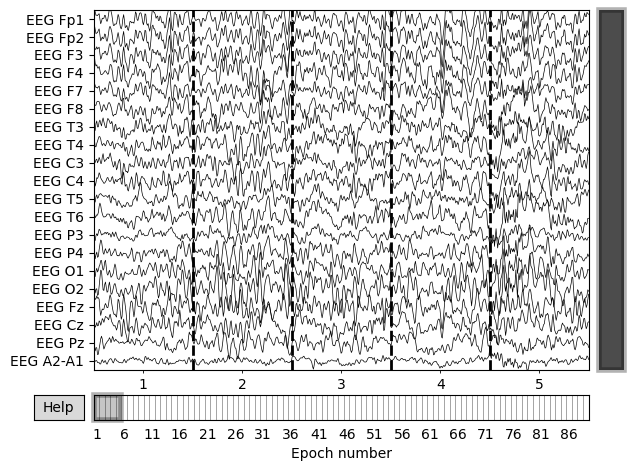

Number of events,89
Events,1: 89
Time range,-0.500 – 0.500 sec
Baseline,off


In [8]:
# Generate synthetic events for epoching
# Assuming events occur at regular intervals of 2 seconds starting from 0 seconds
event_duration = 2.0  # in seconds
n_events = int(raw_data_filtered.times[-1] // event_duration)
events = np.zeros((n_events, 3), dtype=int)
events[:, 0] = np.arange(0, n_events * event_duration, event_duration) * raw_data_filtered.info['sfreq']
events[:, 2] = 1  # All events have the same ID

# Define the time window for each epoch (from -0.5s to +0.5s around each event)
tmin = -0.5  # start time before event
tmax = 0.5  # end time after event

# Create the epochs
epochs = mne.Epochs(raw_data_filtered, events, tmin=tmin, tmax=tmax, baseline=None, detrend=1, preload=True)

# Plot some sample epochs
epochs.plot(n_epochs=5, n_channels=20, scalings='auto', title='Sample Epochs')

epochs


# Analysis

In [9]:
# Calculate and plot the Power Spectral Density (PSD) for the epochs
# Here we compute the PSD for each epoch and then average them for each channel
psds, freqs = mne.time_frequency.psd_multitaper(epochs, fmin=0.5, fmax=50.)
psds_mean = np.mean(psds, axis=0)




    Using multitaper spectrum estimation with 7 DPSS windows


Skipping ECG ECG due to index mismatch.


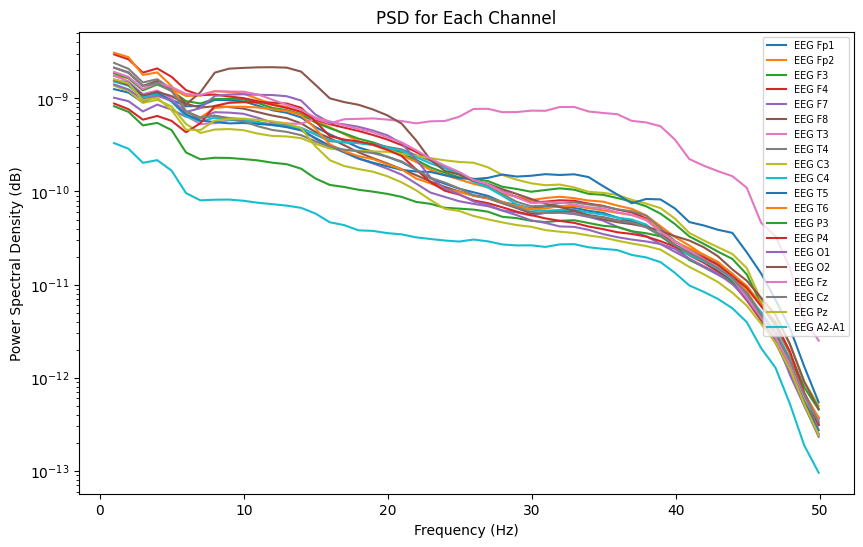

In [10]:
# Plotting the PSD for each channel with their respective labels
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Loop through each channel and plot its average PSD
for i, ch_name in enumerate(epochs.ch_names):
    try:
        ax.semilogy(freqs, psds_mean[i], label=ch_name)
    except IndexError:
        print(f"Skipping {ch_name} due to index mismatch.")

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power Spectral Density (dB)')
ax.set_title('PSD for Each Channel')
ax.legend(loc='upper right', fontsize='x-small')  # Adjust fontsize to fit all labels
plt.show()